<a href="https://colab.research.google.com/github/graphlit/graphlit-evals/blob/main/Tonic_Validate_OpenAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade tonic_validate

In [2]:
!pip install --upgrade openai

In [3]:
import os
from typing import Optional
from tonic_validate import ValidateScorer, Benchmark, BenchmarkItem, LLMResponse, BenchmarkItem, Run
from tonic_validate.metrics import AnswerSimilarityMetric
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import os
import time
from datetime import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import userdata

In [4]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# configure shared, writable folder containing sample data
tonic_validate_directory = "/content/drive/MyDrive/Colab Notebooks/Tonic Validate"

Mounted at /content/drive


Initialize OpenAI

In [5]:
from openai import OpenAI

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

client = OpenAI()

Load benchmark questions & answers

In [6]:
with open(f"{tonic_validate_directory}/Sample Data/qa_pairs.json", "r") as f:
    qa_pairs = json.load(f)

# for testing
qa_pairs = qa_pairs

benchmark = Benchmark(
    questions=[x["question"] for x in qa_pairs],
    answers=[x["answer"] for x in qa_pairs]
)

def run_to_dataframe(run: Run) -> pd.DataFrame:
    return pd.DataFrame(
        {
            "reference_question": [x.reference_question for x in run.run_data],
            "reference_answer": [x.reference_answer for x in run.run_data],
            "llm_answer": [x.llm_answer for x in run.run_data],
            "llm_context": [json.dumps(x.llm_context) for x in run.run_data],
            "answer_similarity": [x.scores["answer_similarity"] for x in run.run_data]
        }
    )

Define OpenAI helper functions

In [7]:
def upload_essays():
    file_ids = []

    directory = f"{tonic_validate_directory}/Sample Data/paul_graham_essays"

    start_time = time.time()

    vector_store = client.beta.vector_stores.create(
      name="OpenAI Rag Test"
    )

    file_paths = [os.path.join(directory, filename) for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))]
    file_streams = [open(path, "rb") for path in file_paths]

    file_batch = client.beta.vector_stores.file_batches.upload_and_poll(
      vector_store_id=vector_store.id, files=file_streams
    )

    duration = time.time() - start_time

    current_time = datetime.now()
    formatted_time = current_time.strftime("%H:%M:%S")

    print(f"Uploading essays took {duration:.2f} seconds. Finished at {formatted_time} UTC.")

    return vector_store.id

def create_assistant(vector_store_id):
    return client.beta.assistants.create(
        name=f"OpenAI Rag Test Files",
        instructions=(
            "You are a chatbot that answers questions about Paul Graham's essays. "
            "Use your knowledge base to best respond to questions. "
            "NO MATTER WHAT, DO NOT PULL INFORMATION FROM EXTERNAL KNOWLEDGE. ONLY USE YOUR OWN KNOWLEDGE BASE."
        ),
        model="gpt-4-turbo",
        tools=[{"type": "file_search"}],
        tool_resources={
          "file_search": {
            "vector_store_ids": [vector_store_id]
          }
        }
    )

# WARNING
# this deletes all vector stores associated with your openai api key.
def cleanup_vector_stores():
    for v in client.beta.vector_stores.list():
        client.beta.vector_stores.delete(v.id)

        print(f'Deleted vector store [{v.id}].')
        time.sleep(1)

def cleanup_files():
    for f in client.files.list():
        client.files.delete(f.id)

        print(f'Deleted file [{f.id}].')
        time.sleep(1)

Define OpenAI RAG function

In [8]:
def get_openai_rag_response(benchmarkItem: BenchmarkItem, assistant):
    prompt = benchmarkItem.question
    thread = client.beta.threads.create(
        messages=[
            {
                "role": "user",
                "content": prompt
            }
        ]
    )
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
    )
    max_retries = 10
    base = 0.1
    num_retries = 0
    try:
        while max_retries > 0:
            if max_retries == 0:
                client.beta.threads.delete(thread.id)
                raise Exception("Max tries exceeded")
            messages = client.beta.threads.messages.list(
                thread_id=thread.id,
            )
            if len(messages.data)>0 and len(messages.data[0].content)>0:
                content = messages.data[0].content[0]
                response_message = content.text.value
                if response_message != prompt and response_message.strip():
#                    annotations = messages.data[0].content[0].text.annotations
#                    quotes = [x.file_citation.quote for x in annotations if x.file_citation]
                    client.beta.threads.delete(thread.id)
                    return response_message
            time.sleep(base * (2 ** num_retries))
            num_retries += 1
            max_retries -= 1
    except Exception as e:
        print(e)
        client.beta.threads.delete(thread.id)
        raise e

Initialize OpenAI test

In [9]:
cleanup_vector_stores()
cleanup_files()

assistant = None

vector_store_id = upload_essays()

if vector_store_id is not None:
    print(f'Essays ingested into vector store [{vector_store_id}].')

    assistant = create_assistant(vector_store_id)

Deleted file [file-K5n65uMWeUmJtbmbNR10ELLv].
Deleted file [file-4lzW13eAZqmaBv9i8QejpqRN].
Deleted file [file-1vOWhUjfkDgLem70lhyXS3Q0].
Deleted file [file-zAa09lqcS5y5TxP5ZjQQkXKw].
Deleted file [file-x1YSAiRFo1OOJx0EiQuiQ4yr].
Deleted file [file-v96URAwEWAGPnX8dh83ylfCB].
Deleted file [file-rWcUEn1J3IKNg8y5vRy8Ynlu].
Deleted file [file-ovI4ysUeE7BkeiQEWd2Y4IWw].
Deleted file [file-iqpwpSYFK23LFtR8dFgxr8On].
Deleted file [file-e1iPsosQ0xRDjfRsPWDNmw9d].
Deleted file [file-ctl6pzrk1bVYTrGVJzCfvRsP].
Deleted file [file-VoJAFrfRwzvtA3Ne8owUMaAK].
Deleted file [file-BdwKLm9RLAdEe6bh4s2zp3Dp].
Deleted file [file-155UWGioFkCKe3TRvnuNXo86].
Deleted file [file-veUxHhtHzKfYKt8aDl0gO5LY].
Deleted file [file-tBoxQE0X73g3DTctUlxGgn3v].
Deleted file [file-r5quANzUyAEsK9W93sdJTG2H].
Deleted file [file-mcqBNMC1bavp1NnYOmTjYDFV].
Deleted file [file-jXO54ZNUx6NPayGeimRhtd3B].
Deleted file [file-fVG5LhzCZHDHxNZuw5XS0QKF].
Deleted file [file-Sb7CYXx1fqBzVBYEeuwk5Jnr].
Deleted file [file-Pw0u9n9Tlo0JtZB

Validate OpenAI response

In [10]:
benchmark_item = BenchmarkItem(
    question="What key components are necessary to create a technology hub according to Paul Graham?",
    answer=""
)

print(get_openai_rag_response(benchmark_item, assistant))

According to Paul Graham, several key components are necessary to create a technology hub:

1. **Rich People**: A technology hub requires rich people who can invest in startups. Wealthy individuals are crucial as they provide the financial resources new firms need to develop their technologies and scale their operations.

2. **Nerds**: A robust presence of intelligent and skilled individuals – the 'nerds' – is also vital. These individuals provide the expertise and innovation required in a thriving tech hub.

3. **Time**: The development of a technology hub doesn't occur overnight. It requires a significant amount of time for the necessary ecosystem to evolve, incorporating education, business development, and networking opportunities to foster a supportive environment for tech companies.

4. **Friendliness to Startups**: The regulatory and cultural environment should be favorable for startups. This includes everything from offering tax benefits to having a local government that suppor

Perform OpenAI test and score run

In [11]:
raw_openai_responses = []
for x in tqdm(benchmark.items):
    raw_openai_responses.append(get_openai_rag_response(x, assistant))

100%|██████████| 55/55 [14:18<00:00, 15.61s/it]


In [12]:
openai_responses = [
    LLMResponse(
        llm_answer=r, llm_context_list=[], benchmark_item=bi
    ) for r, bi in zip(raw_openai_responses, benchmark.items)
]

In [13]:
scorer = ValidateScorer(model_evaluator="gpt-4-turbo", metrics=[AnswerSimilarityMetric()])
openai_run = scorer.score_run(openai_responses, parallelism=5)

Scoring responses:   4%|▎         | 2/55 [00:00<00:15,  3.32it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Scoring responses:   7%|▋         | 4/55 [00:01<00:11,  4.34it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Scoring responses:  11%|█         | 6/55 [00:01<00:07,  6.57it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Scoring responses:  15%|█▍        | 8/55 [00:01<00:05,  8.28it/s]INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Scoring resp

In [14]:
openai_run_df = run_to_dataframe(openai_run)
openai_run_df.to_csv(f"{tonic_validate_directory}/openai_run.csv", index=False)

Visualize OpenAI test

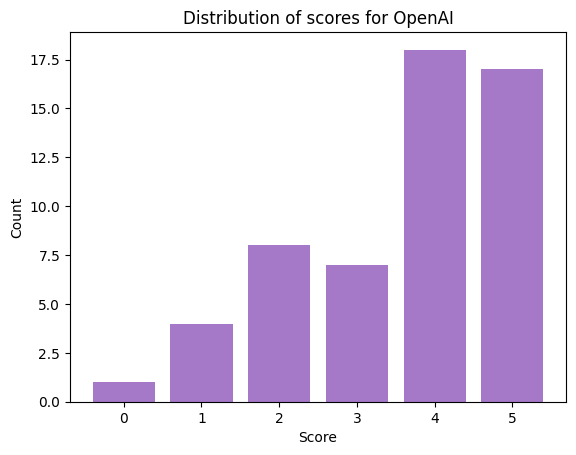

In [15]:
openai_answer_similarity_scores = pd.Series([x.scores["answer_similarity"] for x in openai_run.run_data])
category_counts = openai_answer_similarity_scores.value_counts()
plt.bar(category_counts.index, category_counts.values)

plt.title('Distribution of scores for OpenAI')
plt.xlabel('Score')
plt.ylabel('Count')

plt.bar(category_counts.index, category_counts.values, color='#A679C8')

# Remove all scores except whole numbers
plt.xticks(range(0, 6, 1))

plt.show()